### 1. Load the Dataset and Perform Initial Inspection

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
import re

pd.set_option('display.max_columns', None)  # display all columns
pd.set_option('display.max_rows', None)     # display all rows

# Load the dataset
df = pd.read_csv('data/NZ airfares.csv')

In [103]:
df.head()  # Display the first 5 rows of the dataset

,Travel Date,Dep. airport,Dep. time,Arr. airport,Arr. time,Duration,Direct,Transit,Baggage,Airline,Airfare(NZ$)
0,19/09/2019,AKL,1:35 PM,CHC,3:00 PM,1h 25m,(Direct),NaN,NaN,Jetstar,111
1,19/09/2019,AKL,3:55 PM,CHC,5:20 PM,1h 25m,(Direct),NaN,NaN,Jetstar,111
2,19/09/2019,AKL,11:40 AM,CHC,1:05 PM,1h 25m,(Direct),NaN,NaN,Jetstar,132
3,19/09/2019,AKL,8:00 PM,CHC,9:25 PM,1h 25m,(Direct),NaN,NaN,Jetstar,132
4,19/09/2019,AKL,9:00 AM,CHC,10:25 AM,1h 25m,(Direct),NaN,NaN,Air New Zealand,133


In [104]:
df.shape  # Display the shape of the dataset

(162833, 11)

In [105]:
df.info()  # Display basic information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162833 entries, 0 to 162832
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Travel Date   162833 non-null  object
 1   Dep. airport  162809 non-null  object
 2   Dep. time     162833 non-null  object
 3   Arr. airport  162809 non-null  object
 4   Arr. time     162828 non-null  object
 5   Duration      162833 non-null  object
 6   Direct        162833 non-null  object
 7   Transit       123077 non-null  object
 8   Baggage       2311 non-null    object
 9   Airline       162828 non-null  object
 10  Airfare(NZ$)  162833 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 13.7+ MB


In [106]:
df.describe().transpose()  # Display summary statistics of the dataset

,count,mean,std,min,25%,50%,75%,max
Airfare(NZ$),162833.0,411.031769,168.958742,32.0,293.0,392.0,512.0,1364.0


In [107]:
df.columns  # Display the columns in the dataset

Index(['Travel Date', 'Dep. airport', 'Dep. time', 'Arr. airport', 'Arr. time',
       'Duration', 'Direct', 'Transit', 'Baggage', 'Airline', 'Airfare(NZ$)'],
      dtype='object')

### 2. Data Preprocessing

In [108]:

# check duplicates in each column and print the count of duplicates for each column
for column in df.columns:
    duplicates = df[column].duplicated().sum()
    print(f"Column: '{column}' ")
    print(f"Duplicate count: {duplicates} \n")
duplicates = df.duplicated().sum()
print(f"Total duplicates in the dataset: {duplicates}")

Column: 'Travel Date' 
Duplicate count: 162743 

Column: 'Dep. airport' 
Duplicate count: 162828 

Column: 'Dep. time' 
Duplicate count: 162651 

Column: 'Arr. airport' 
Duplicate count: 162823 

Column: 'Arr. time' 
Duplicate count: 162643 

Column: 'Duration' 
Duplicate count: 162557 

Column: 'Direct' 
Duplicate count: 162829 

Column: 'Transit' 
Duplicate count: 161612 

Column: 'Baggage' 
Duplicate count: 162831 

Column: 'Airline' 
Duplicate count: 162829 

Column: 'Airfare(NZ$)' 
Duplicate count: 161966 

Total duplicates in the dataset: 1841


In [109]:
df.isnull().sum()  # Check for missing values in each column

Travel Date          0
Dep. airport        24
Dep. time            0
Arr. airport        24
Arr. time            5
Duration             0
Direct               0
Transit          39756
Baggage         160522
Airline              5
Airfare(NZ$)         0
dtype: int64

In [110]:
# Drop rows with missing critical information
df = df.dropna(subset=['Dep. airport', 'Arr. airport', 'Arr. time', 'Airline']) 

In [111]:
# Fill missing 'Transit' values as 'No Transit'
df['Transit'] = df['Transit'].fillna('No Transit')

In [112]:
# Calculate the percentage of missing values in the 'Baggage' column
missing_baggage_pct = df['Baggage'].isnull().mean() * 100
print(f"Percentage of missing values in 'Baggage': {missing_baggage_pct:.2f}%")

Percentage of missing values in 'Baggage': 98.58%


In [113]:
# Drop 'Baggage' column due to excessive missing values
df = df.drop(columns=['Baggage'])

In [114]:
# Check for missing values in each column after cleaning
print("\nMissing value report (after cleaning):")
df.isnull().sum() 


Missing value report (after cleaning):


Travel Date     0
Dep. airport    0
Dep. time       0
Arr. airport    0
Arr. time       0
Duration        0
Direct          0
Transit         0
Airline         0
Airfare(NZ$)    0
dtype: int64

### 3. Feature Engineering

In [115]:
# (a) Parse travel date
# - Extract parts (day of week, month) efficiently.
# - Sort, filter, compute time differences.
# - Avoid string comparison errors.
df['Travel Date'] = pd.to_datetime(df['Travel Date'], format='%d/%m/%Y', errors='coerce')

# (b) Parse times (12h to hour)
# Converting departure / arrival time strings into integer hour values (DepHour, ArrHour):
# - Produces numeric features usable by ML models (most models can’t use raw time strings).
# - Enables aggregation (average fare by hour) and detecting peak pricing periods.
# - Reduces noise (minute-level granularity usually unnecessary for fare patterns).
def to_hour(t):
    try:
        return pd.to_datetime(t.strip(), format='%I:%M %p').hour
    except:
        return np.nan

df['DepHour'] = df['Dep. time'].apply(to_hour)
df['ArrHour'] = df['Arr. time'].apply(to_hour)

# (c) Convert duration "1h 25m" to minutes
# - Standardizes mixed text format into a continuous variable.
# - Captures flight length (proxy for distance / cost driver).
# - Facilitates correlation analysis and feature scaling.
def duration_to_minutes(s):
    if not isinstance(s, str):
        return np.nan
    h = re.search(r'(\d+)h', s)
    m = re.search(r'(\d+)m', s)
    total = 0
    if h: total += int(h.group(1)) * 60
    if m: total += int(m.group(1))
    return total

df['DurationMin'] = df['Duration'].apply(duration_to_minutes)

# (d) Route & temporal flags
# Route = Dep + Arr creates a categorical identifier for origin–destination pair (key fare determinant).
# DayOfWeek and Month capture temporal demand patterns (business vs leisure days, seasonal effects).
# IsWeekend (binary) simplifies a common split (weekend leisure demand).
# These features encode time-based variability affecting pricing.
df['Route'] = df['Dep. airport'] + '-' + df['Arr. airport']
df['DayOfWeek'] = df['Travel Date'].dt.dayofweek
df['Month'] = df['Travel Date'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# (e) Flight type indicators
# IsDirect converts textual “Direct” label into a binary indicator; direct flights often priced at a premium.
# HasTransit flags presence of connections; may lower or raise fare depending on market.
# Binary flags make flight-type effects explicit and model-friendly.
df['IsDirect'] = df['Direct'].str.contains('Direct', case=False, na=False).astype(int)
df['HasTransit'] = (df['Transit'] != 'No Transit').astype(int)


In [116]:
# Outlier Handling (Fare)
# Identify and reduce the influence of unusually high airfare values that can distort analysis and model training. 
fare_col = 'Airfare(NZ$)'
Q1, Q3 = df[fare_col].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR
lower_cap = max(Q1 - 1.5 * IQR, 0)
extreme_high = (df[fare_col] > upper_cap).sum()
print(f"\nFare outlier upper bound: {upper_cap:.2f}; extreme high rows: {extreme_high}")
# Winsorize (cap) to reduce undue influence
df[fare_col] = np.where(df[fare_col] > upper_cap, upper_cap, df[fare_col])
df[fare_col] = np.where(df[fare_col] < lower_cap, lower_cap, df[fare_col])

print("\nFare distribution after capping:")
display(df[fare_col].describe())


Fare outlier upper bound: 840.50; extreme high rows: 3121

Fare distribution after capping:


count    162804.000000
mean        409.581721
std         164.565819
min          32.000000
25%         293.000000
50%         392.000000
75%         512.000000
max         840.500000
Name: Airfare(NZ$), dtype: float64

### 4. EDA

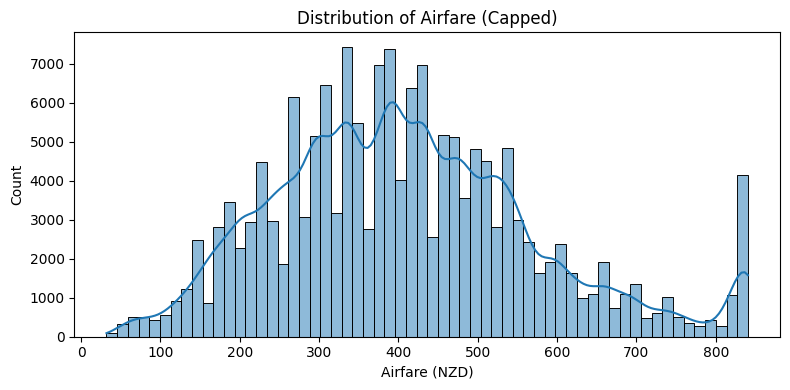

In [117]:
# Airfare distribution (histogram + KDE)
plt.figure(figsize=(8,4))
sns.histplot(df[fare_col], bins=60, kde=True)
plt.title('Distribution of Airfare (Capped)')
plt.xlabel('Airfare (NZD)')
plt.tight_layout()
plt.show()


Insights

- After capping, distribution still mildly right‑skewed but long extreme tail removed.
- Majority fares cluster in a mid‑price band (typical core market).
- Remaining skew suggests a log transform could still be tested for linear models.

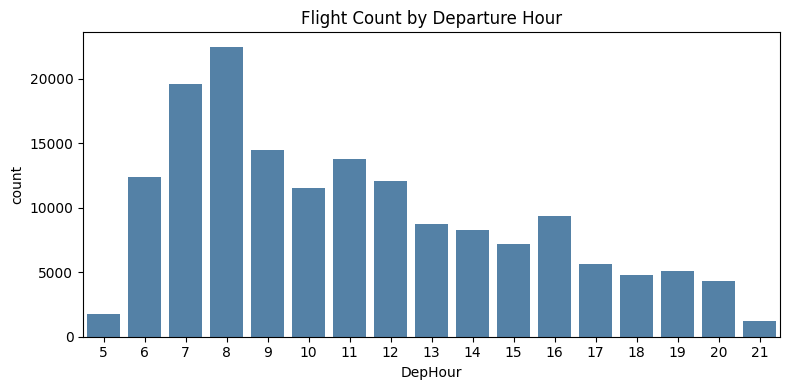

In [118]:

# Departure hour count plot 
plt.figure(figsize=(8,4))
sns.countplot(x='DepHour', data=df, color='steelblue')
plt.title('Flight Count by Departure Hour')
plt.tight_layout()
plt.show()

Insights

- Flights concentrate in a few daytime bands (7:00-11:00, 16:00-17:00).

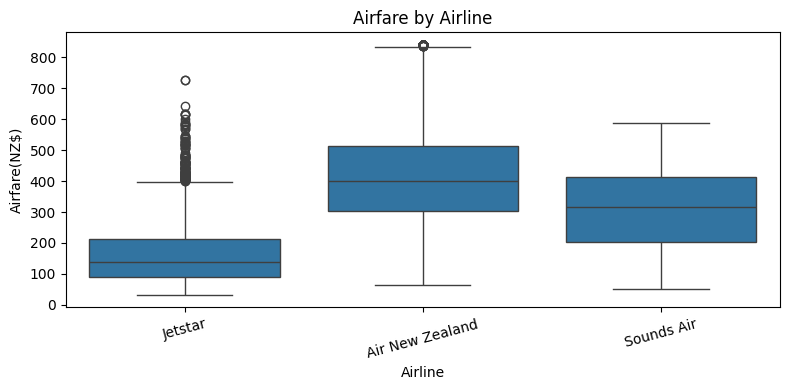

In [119]:
# Boxplot of Airfare by Airline
plt.figure(figsize=(8,4))
sns.boxplot(x='Airline', y=fare_col, data=df)
plt.title('Airfare by Airline')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Insights


- Clear median and IQR separation across airlines → strong discriminatory feature.
- Lower‑cost carrier shows compressed, lower distribution; full‑service carrier higher median and wider spread (fare differentiation / ancillary packaging).

/var/folders/tb/7d6p8xp17pd395ykj3qlw4fc0000gn/T/ipykernel_31595/2948397185.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y=fare_col, data=dow_mean, palette='viridis')


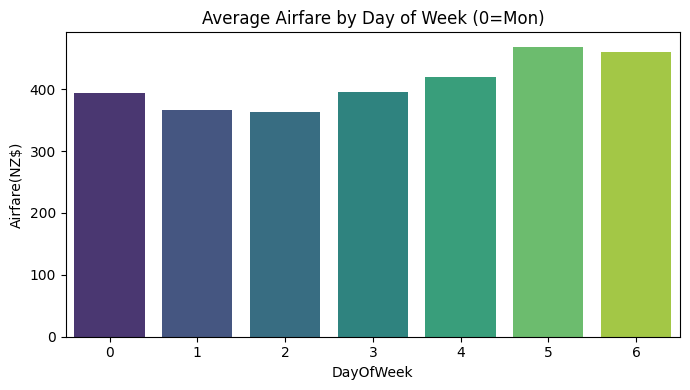

In [120]:
# Average fare by DayOfWeek and Route
dow_mean = df.groupby('DayOfWeek')[fare_col].mean().reset_index()
plt.figure(figsize=(7,4))
sns.barplot(x='DayOfWeek', y=fare_col, data=dow_mean, palette='viridis')
plt.title('Average Airfare by Day of Week (0=Mon)')
plt.tight_layout()
plt.show()


Insights


- Average fares on weekends are slightly higher than on weekdays, with the difference noticeable but not substantial.
- This pattern suggests temporal demand effect exists but is secondary to route/airline.

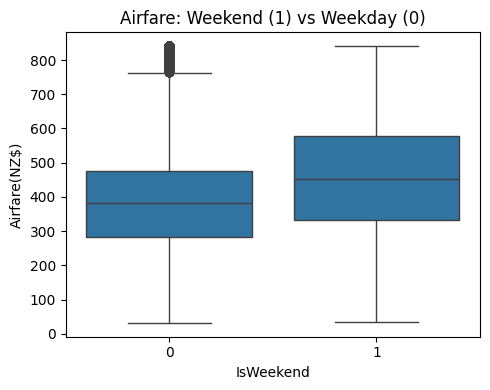

In [ ]:

# Weekend vs weekday boxplot
plt.figure(figsize=(5,4))
sns.boxplot(x='IsWeekend', y=fare_col, data=df)
plt.title('Airfare: Weekend (1) vs Weekday (0)')
plt.tight_layout()
plt.show()


Insights


- Weekend distribution shifts (median change) indicating leisure demand pricing difference.
- Justifies retaining IsWeekend as a binary feature.

In [127]:
# Route coverage (volume + cumulative share)
route_stats = (df.groupby('Route')['Airfare(NZ$)']
                 .agg(['count','mean'])
                 .rename(columns={'count':'RouteCount','mean':'RouteMean'})
                 .sort_values('RouteCount', ascending=False))
route_stats['CumShare'] = route_stats['RouteCount'].cumsum() / route_stats['RouteCount'].sum()
print(route_stats.head(15))
print("\nTop 10 routes volume share: {:.1%}".format(route_stats['RouteCount'].head(10).sum() / route_stats['RouteCount'].sum()))


         RouteCount   RouteMean  CumShare
Route                                    
CHC-AKL        6379  382.744161  0.039182
AKL-CHC        6030  377.847927  0.076220
AKL-NSN        5960  329.200084  0.112829
WLG-CHC        5821  391.682701  0.148584
WLG-NSN        5735  371.604098  0.183810
CHC-WLG        5713  398.630667  0.218901
WLG-DUD        5665  377.258870  0.253698
AKL-DUD        5660  355.668816  0.288463
CHC-NPE        5660  428.741873  0.323229
ZQN-AKL        5426  398.678492  0.356558
ZQN-NSN        5418  424.550480  0.389837
WLG-AKL        5417  416.771460  0.423110
AKL-WLG        5366  419.765654  0.456070
CHC-NPL        5357  349.804555  0.488974
WLG-ZQN        5291  371.486108  0.521474

Top 10 routes volume share: 35.7%


Insights

- The top 15 routes already account for over 52% of the dataset, with just the top 10 covering 35.7% of all observations.
- This suggests a long-tail distribution: a handful of trunk routes (e.g., CHC–AKL, AKL–CHC, AKL–NSN) dominate the volume, while many other routes have only a small number of observations.
- The dominance of CHC–AKL and AKL–CHC (together ~7.6% of the total) reflects the strong demand on these key inter-island corridors.


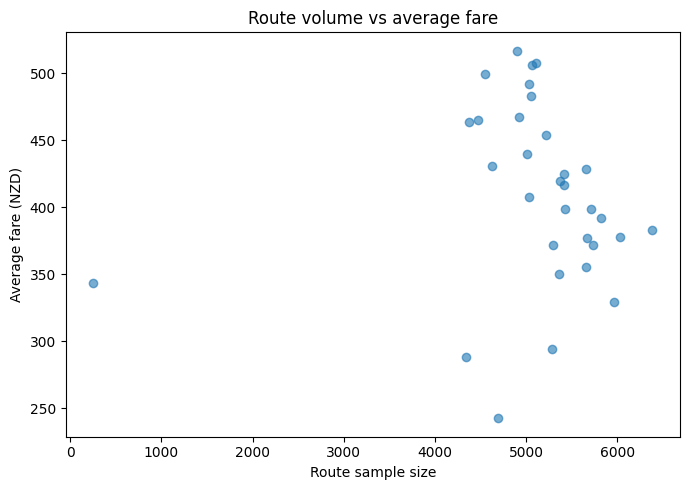

In [126]:

# Volume vs mean fare scatter (filter tiny routes)
filtered = route_stats[route_stats['RouteCount'] >= 3]
plt.figure(figsize=(7,5))
plt.scatter(filtered['RouteCount'], filtered['RouteMean'], alpha=0.6)
plt.xlabel("Route sample size")
plt.ylabel("Average fare (NZD)")
plt.title("Route volume vs average fare")
plt.tight_layout()
plt.show()


Insights

- The scatterplot shows that high-volume routes cluster around average fares of NZD 350–420.
- A few low-volume routes have fares outside this band (both cheaper and more expensive), but these are statistical outliers and less commercially significant due to small sample size.
- The flat relationship indicates that larger sample size does not strongly correlate with lower fares—high demand does not automatically mean cheaper prices.


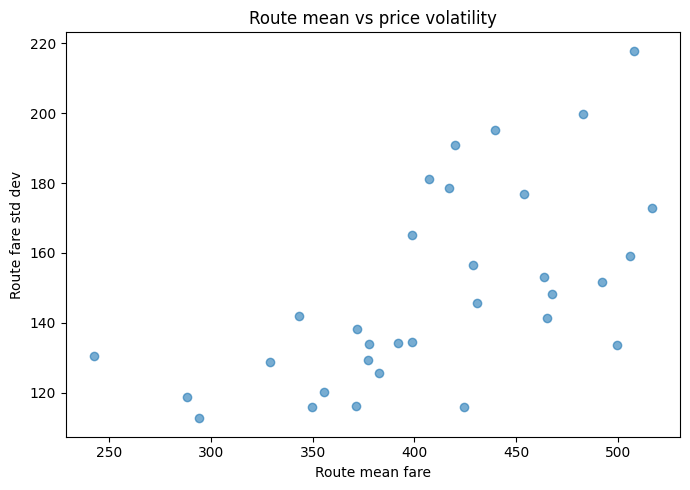

In [128]:

# Mean vs variability
route_stats['Std'] = df.groupby('Route')['Airfare(NZ$)'].std()
plt.figure(figsize=(7,5))
plt.scatter(route_stats['RouteMean'], route_stats['Std'], alpha=0.6)
plt.xlabel("Route mean fare")
plt.ylabel("Route fare std dev")
plt.title("Route mean vs price volatility")
plt.tight_layout()
plt.show()

Insights

- There is a positive association between mean fare and fare volatility (std dev). Routes with higher average fares (NZD 450–500) tend to also have more volatile pricing (std dev up to ~200).
- Lower-fare routes (NZD 300–350) generally show tighter dispersion, suggesting more consistent and predictable pricing.
- This pattern is consistent with leisure-heavy or tourist routes (e.g., Queenstown, Napier) having both higher mean fares and higher variability due to seasonality and demand shocks, while commuter routes (e.g., AKL–NSN, WLG–CHC) are steadier.

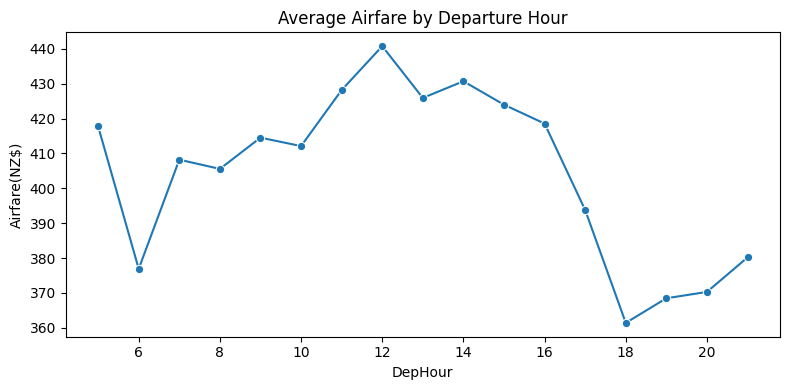

In [ ]:

# Average fare by departure hour to see pricing patterns
hour_mean = df.groupby('DepHour')[fare_col].mean().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(x='DepHour', y=fare_col, data=hour_mean, marker='o')
plt.title('Average Airfare by Departure Hour')
plt.tight_layout()
plt.show()

Insights

- Fare curve shows mild peaks aligned with operational demand waves (e.g., business commute windows).
- Supports potential engineered feature: PeakHour or time‑of‑day bins.


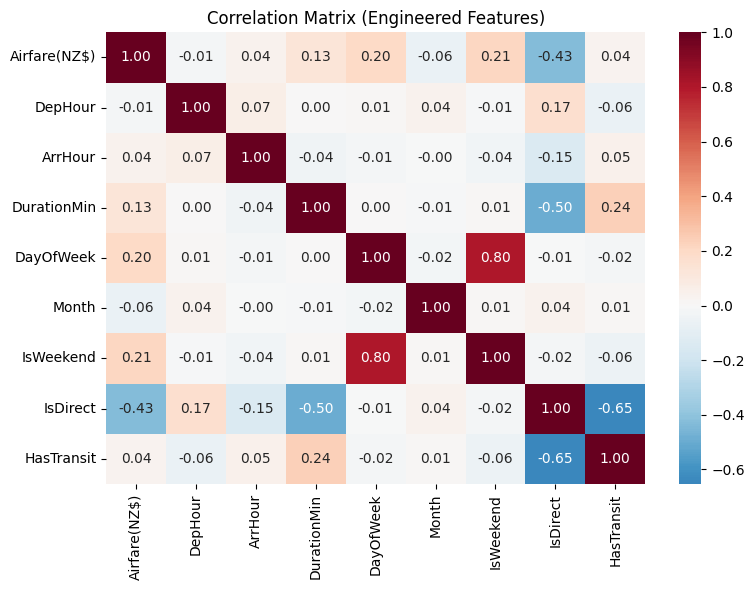


Correlation with Fare (descending):
Airfare(NZ$)    1.000000
IsWeekend       0.213706
DayOfWeek       0.201967
DurationMin     0.130180
ArrHour         0.040842
HasTransit      0.036138
DepHour        -0.014197
Month          -0.060705
IsDirect       -0.433411
Name: Airfare(NZ$), dtype: float64


In [ ]:
# Correlation Matrix
numeric_cols = ['Airfare(NZ$)','DepHour','ArrHour','DurationMin','DayOfWeek','Month','IsWeekend','IsDirect','HasTransit']
corr_df = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Correlation Matrix (Engineered Features)')
plt.tight_layout()
plt.show()

print("\nCorrelation with Fare (descending):")
print(corr_df['Airfare(NZ$)'].sort_values(ascending=False))


Insights

- Strongest absolute linear relationship with fare is IsDirect (r ≈ -0.43). Negative sign means direct flights are cheaper on average in this sample. This finding is counterintuitive relative to industry norms, but may reflect that multi-leg itineraries in the dataset often include longer durations or high-priced outliers.
- Weekend effect is moderate (IsWeekend r ≈ +0.21) indicating a modest uplift; useful but not dominant.
- DurationMin has only weak positive correlation (≈ +0.13); route likely already captures most distance/length pricing structure, so duration adds limited incremental linear signal alone.
- Other temporal features (DepHour, ArrHour, DayOfWeek, Month) show low simple correlations, suggesting non‑linear or interaction effects rather than strong standalone linear influence.
- Low pairwise correlations among predictors (no high multicollinearity).




### 5. Potential Questions

1. Do different airlines significantly influence airfare pricing?

   Yes. Boxplots show clear separation in median and spread between carriers. Low-cost airlines have lower and more compressed fare distributions, while full-service airlines exhibit higher medians and wider price ranges .


2. Does route demand (volume) lead to cheaper fares?

   Not necessarily. The busiest routes (e.g., CHC–AKL, AKL–CHC) dominate volume but cluster around mid-range fares (NZD 350–420). Scatterplots indicate that high demand does not automatically translate to lower prices .


3. How do temporal factors such as weekends affect fares?

   Weekend flights are priced slightly higher on average than weekday flights. This suggests a modest leisure-demand effect, though the uplift is secondary compared to route and airline effects .

4. Do peak departure hours (morning, late afternoon) carry a pricing uplift beyond route and airline?

   Line plot of average fare by hour shows structured mild peaks—candidate engineered PeakHour feature to test incremental lift.

